In [1]:
import numpy as np 
import pandas as pd
import subprocess
import os
import torchvision.models as models
import torchvision
import torch
import matplotlib.pyplot as plt
import scipy
import scipy.ndimage
import time
import random

from numpy import unravel_index

from tqdm import tqdm

from copy import deepcopy

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from torchsummary import summary

from xml.dom import minidom
from os.path import basename

from PIL import Image

from labels_imagenet import labels_dict
from functions_imagenet import *

In [2]:
# Global variables
dataroot     = '/home/people/16206131/scratch'
xml_folder   = dataroot + '/data/ILSVRC/Annotations/CLS-LOC/train/'
train_folder = dataroot + '/data/ILSVRC/Data/CLS-LOC/train/'
val_folder   = dataroot + '/data/ILSVRC/Data/CLS-LOC/val/'
IMG_SIZE     = 224
WORKERS      = 1
BATCH_SIZE   = 1
MEAN_NORM=(0.485, 0.456, 0.406)
STD_NORM=(0.229, 0.224, 0.225)
FILTER_SIZE = 7

dataroot     = '/home/people/16206131/scratch'
train_folder = dataroot + '/data/ILSVRC/Data/CLS-LOC/train/'
val_folder   = dataroot + '/data/ILSVRC/Data/CLS-LOC/val/'
IMG_SIZE     = 224
WORKERS      = 0
BATCH_SIZE   = 1
DEVICE       = 'cpu'

# Hyperparameter
ALPHA = 4

In [3]:
transformNoNormalize = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])


normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transformNormalize = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
])

In [4]:
train_loader, val_loader, train_dataset, val_dataset = imagenet_dataloaders()

In [5]:
label_converter = get_labels_dict()

In [6]:
class NetC(torch.nn.Module):

    def __init__(self, net):
        super(NetC, self).__init__()
        self.net = net
        self.main = torch.nn.Sequential(*list(self.net.children()))[:-2]
        self.avgpool = net.avgpool
        self.linear = net.fc 

    def forward(self, x):
        C = self.main(x)      
        x = self.avgpool(C)  
        x = x.view(x.shape[0], x.shape[1])
        logits = self.linear(x)
        return logits, x, C

In [7]:
FOLDER = 'twin_data'

In [8]:
resnet = models.resnet50(pretrained=True).eval()
netC = NetC(resnet)

In [9]:
X_train_cont = np.load(dataroot + '/sonic_collect_twin_data_imagenet/'+FOLDER+'/X_train_cont.npy')
X_train_act  = np.load(dataroot + '/sonic_collect_twin_data_imagenet/'+FOLDER+'/X_train_act.npy')
y_train_pred = np.load(dataroot + '/sonic_collect_twin_data_imagenet/'+FOLDER+'/y_train_pred.npy')
X_val_cont   = np.load(dataroot + '/sonic_collect_twin_data_imagenet/'+FOLDER+'/X_val_cont.npy')
X_val_act    = np.load(dataroot + '/sonic_collect_twin_data_imagenet/'+FOLDER+'/X_val_act.npy')
y_val_pred   = np.load(dataroot + '/sonic_collect_twin_data_imagenet/'+FOLDER+'/y_val_pred.npy')

## Make Twin Explainer

In [10]:
twin = KNeighborsClassifier(n_neighbors=1)

In [11]:
twin.fit(X_train_cont, y_train_pred)

KNeighborsClassifier(n_neighbors=1)

## Pick Test Instance and Go!

In [12]:
def print_xp_by_example():

    f, axarr = plt.subplots(1, 4, figsize=(25,25))
    query = transformNoNormalize(Image.open( val_dataset.img_dir + val_dataset.img_names[QUERY_IDX] ).convert('RGB')).permute(1,2,0) 
    axarr[0].imshow( query )
    axarr[0].axis('off')
    axarr[0].title.set_text('Label: ' +  str(labels_dict[QUERY_LABEL.item()]) + ' \n Pred: ' + str(labels_dict[QUERY_PRED.item()]))

    for i in range(3):
        xp1 = transformNoNormalize(Image.open(train_dataset.imgs[NEIGHBORS[i]][0]).convert('RGB')).permute(1,2,0)
        axarr[i+1].imshow(xp1)
        axarr[i+1].axis('off')
        axarr[i+1].title.set_text('Label: ' +  str(labels_dict[train_dataset.targets[NEIGHBORS[i]]]) + ' \n Pred: ' + str(labels_dict[y_train_pred[ NEIGHBORS[i] ]] ))
        plt.savefig('materials/' + str(QUERY_IDX) + '_ebe.pdf')

In [13]:
def find_closest_coords(Conv, xp_feature, use_contributions=False, use_cosine=False):
    """
    Use Euclidean Distance
    """
    
    pred_weights = netC.linear.weight.clone()[QUERY_PRED].detach().numpy()
    xp_feature   = xp_feature.view(1, 2048).clone().detach().numpy()
    cos          = torch.nn.CosineSimilarity(dim=1)
    
    
    if use_contributions:
        xp_feature *= pred_weights
        
    if use_cosine:
        xp_feature = (xp_feature - np.min(xp_feature))/np.ptp(xp_feature)

        
    max_dist = float('inf')
    max_sim = 0.
    
    coord = [None, None]
    for i in range(Conv.shape[2]):
        for j in range(Conv.shape[3]):
            
            query_seg = Conv[:, :, i:i+1, j:j+1 ].clone()
            query_seg = query_seg.view(1, 2048).detach().numpy()
            
            if use_contributions:
                query_seg *= pred_weights
                                
                
            if use_cosine:
                query_seg = (query_seg - np.min(query_seg))/np.ptp(query_seg)
                new_sim = cos(torch.tensor(query_seg), torch.tensor(xp_feature)).item()
                if new_sim > max_sim:
                    max_sim = new_sim
                    coord = [i, j]
            else:
                new_dist = torch.cdist(torch.tensor(query_seg), torch.tensor(xp_feature), p=2.0).item()  
                if new_dist < max_dist:
                    max_dist = new_dist
                    coord = [i, j]
    if use_cosine:         
        return coord, max_sim
    else:         
        return coord, max_dist

In [14]:
class netClassifier(torch.nn.Module):
    
    def __init__(self, netC):
        super(netClassifier, self).__init__()
        self.net = netC
        
    def forward(self, C):
        x = self.net.avgpool(C)
        x = x.view(-1, 2048)
        logits = self.net.linear(x)
        return logits

In [15]:
def inverse_normalize(in_tensor, mean=MEAN_NORM, std=STD_NORM):
    tensor = in_tensor.clone().detach()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

In [16]:
def get_transformed_traning_data(idx, loader):
    """
    Takes in indexs and a dataloader
    returns: Those indexs transformed
    """
    
    img = new_transform(  Image.open(train_dataset.imgs[idx][0]).convert('RGB')  ).view(-1,3,IMG_SIZE, IMG_SIZE)

    return img

In [17]:
def get_cam(C, pred):
    test_weights = weights[pred].detach().numpy()
    C_conts = test_weights.reshape(test_weights.shape[0],1,1) * C[0].detach().numpy()
    return C_conts.sum(axis=0)


def get_max_2d(a):
    maxindex = a.argmax()
    return unravel_index(a.argmax(), a.shape)


def get_salient_regions(Conv, org_logits, net_classifier):
    
    query_pred = torch.argmax(org_logits, dim=1)
    q_cam = get_cam(Conv, query_pred.item())
    q_i, q_j = get_max_2d(q_cam)
    q_feature = Conv[:, :, q_i:q_i+1, q_j:q_j+1 ]
    q_saliency = q_cam[q_i][q_j]
            
    return [[q_saliency, [q_i, q_j], q_feature]]

### Functions for AB-CAM

In [18]:
def cam_xp(C_conts, training=True, training_idx = 0):
    
    if training:
        img = Image.open(train_dataset.imgs[NEIGHBORS[training_idx]][0]).convert('RGB')
        img = transformNoNormalize( img ).permute(1,2,0)
    else:
        img = transformNoNormalize(Image.open( val_dataset.img_dir + val_dataset.img_names[QUERY_IDX] )).permute(1,2,0) 
    
    plt.imshow( img, alpha=1 )
    activations = C_conts.sum(axis=0)
    FAM = scipy.ndimage.zoom(activations, (32, 32), order=3) 
    plt.imshow(FAM, cmap='jet', alpha=0.4)
    plt.axis('off')


In [19]:
def get_coords_nb_feature_in_nn(Conv, cam, query_feature):

    # Threshold for saliency
    alpha = cam.max() / ALPHA
    coords = None
    max_dist = float('inf')
    for i in range(Conv.shape[2]):
        for j in range(Conv.shape[3]):
            temp_feature = Conv[:, :, i:i+1, j:j+1 ]
            dist = torch.cdist(query_feature.view(-1, 2048), temp_feature.view(-1, 2048), p=2.0).item() 
            
            if cam[i][j] > alpha:
                if dist < max_dist:
                    max_dist = dist
                    coords = [i, j]
                    
    return max_dist, coords

In [20]:
def show_twin_sys_explanation_with_blackout(img, netC):
    """
    Show more nns
    """
    
    num_features_to_show = 1
    
    net_classifier = netClassifier(netC)
    unit = IMG_SIZE / FILTER_SIZE
    
    original_logits, original_x, original_C = netC(img)
        
    query_nb_boxes = get_salient_regions(original_C, original_logits, net_classifier)  # in conv layer
        
    f, axarr = plt.subplots(num_features_to_show,4, figsize=(25,25))

    for i_idx in range(num_features_to_show):

        coord = query_nb_boxes[i_idx][1]
        xxx = transformNoNormalize(Image.open(val_dataset.img_dir + val_dataset.img_names[QUERY_IDX]).convert('RGB')).permute(1,2,0) 
        axarr[ 0].imshow( xxx )
        
        x = coord[1] * unit
        y = coord[0] * unit

        axarr[0].plot([x, x], [y, y+unit], color='yellow')
        axarr[ 0].plot([x, x+unit], [y, y], color='yellow')
        axarr[ 0].plot([x+unit, x+unit], [y, y+unit], color='yellow')
        axarr[ 0].plot([x, x+unit], [y+unit, y+unit], color='yellow')       
        axarr[ 0].axis('off')
        axarr[ 0].title.set_text('Feature ' +  str(i_idx+1) + ' \n Saliency:' +  str(query_nb_boxes[i_idx][0] ) )

        
        
        ### XP Plot ==================================
        
        # Get latent feature from original query
        query_feature = query_nb_boxes[i_idx][2]

        
        results = list()
        
        for nn_idx in range(len(NEIGHBORS)):
            nn_img = Image.open(train_dataset.imgs[NEIGHBORS[nn_idx]][0]).convert('RGB')
            nn_img = transformNormalize(nn_img).view(-1, 3, IMG_SIZE, IMG_SIZE)
            nn_logits, nn_x, nn_C = netC(nn_img)
            nn_pred = torch.argmax(nn_logits, dim=1).item()
            nn_cam = get_cam(nn_C, nn_pred)
            
                        
            new_dist, nn_coords = get_coords_nb_feature_in_nn(nn_C, nn_cam, query_feature)
            results.append([new_dist, nn_idx, nn_coords, nn_cam])

        results = sorted(results, key=lambda x: x[0], reverse=False) 

        
        for xp_number in range(3):
            
            xp_dist, closest_example_idx, xp_coord, xp_ab_cam = results[xp_number]  
            
            xp_img_raw = Image.open(train_dataset.imgs[NEIGHBORS[closest_example_idx]][0]).convert('RGB')
            xp_img = transformNormalize( xp_img_raw ).view(-1, 3,IMG_SIZE,IMG_SIZE)
            xp_logits, _, xp_C = netC(xp_img)

            img_for_plotting = transformNoNormalize(xp_img_raw).permute(1,2,0) 
            axarr[ xp_number+1].imshow( img_for_plotting )

            x = xp_coord[1] * unit
            y = xp_coord[0] * unit
        
            axarr[ xp_number+1].plot([x, x], [y, y+unit], color='yellow')
            axarr[ xp_number+1].plot([x, x+unit], [y, y], color='yellow')
            axarr[ xp_number+1].plot([x+unit, x+unit], [y, y+unit], color='yellow')
            axarr[ xp_number+1].plot([x, x+unit], [y+unit, y+unit], color='yellow')
            axarr[ xp_number+1].axis('off')
            axarr[ xp_number+1].title.set_text('Distance ' +  str( round(xp_dist,2)  ) + '\n Saliency:' + str(xp_ab_cam[xp_coord[0]][xp_coord[1]]) )
        
        
    plt.savefig('materials/' + str(QUERY_IDX) + '_Box.pdf')
        
    return NEIGHBORS[results[0][1] ]

## Go

Labels
https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

In [21]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])


normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

new_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
])


### Correct Classification "Fillers"

In [22]:
correct_materials = [153, 2418, 8064, 2532, 14313, 1161, 1495, 897]

#### Material Set A

In [23]:
material_set_a = [25852, 871, 2105, 1197, 1711, 6526, 20974, 655, 24152, 24251, 24716, 25608]

#### Material Set B

In [25]:
material_set_b = [8774, 12040, 9604, 9795, 9966, 11549, 40624, 29997, 32836, 45651, 35433, 37334]

Label: snail
Pred: snail
IDX 153


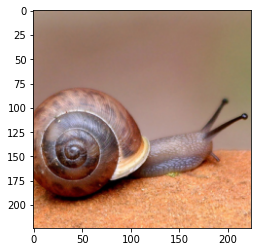

In [26]:
QUERY_IDX = correct_materials[0]

print("Label:", labels_dict[val_dataset.y[QUERY_IDX]] )
print("Pred:", labels_dict[y_val_pred[QUERY_IDX]])
print('IDX', QUERY_IDX)
xxx = transform(Image.open(val_dataset.img_dir + val_dataset.img_names[QUERY_IDX]).convert('RGB')).permute(1,2,0) 
plt.imshow( xxx )

In [27]:
QUERY_LABEL = val_dataset.y[QUERY_IDX]
QUERY_PRED = y_val_pred[QUERY_IDX]
RAW_QUERY_IMG = Image.open(val_dataset.img_dir+val_dataset.img_names[QUERY_IDX]).convert('RGB')

start_time = time.time()
QUERY_IMG = transformNormalize(RAW_QUERY_IMG).view(-1,3,IMG_SIZE, IMG_SIZE)
QUERY_CONT = X_val_cont[QUERY_IDX]
XP_IDXS = twin.kneighbors(X=[QUERY_CONT], n_neighbors=50, return_distance=False)
temp_NEIGHBORS = XP_IDXS[0]
print("Took Sec:", time.time() - start_time)
print('IDX', QUERY_IDX)

Took Sec: 29.637898206710815
IDX 153


In [28]:
#### Remove NNs which are not correctly classifed and in the same class
NEIGHBORS = list()
for nn in temp_NEIGHBORS:
    if train_dataset.targets[nn] == QUERY_PRED:
        if y_train_pred[nn] == QUERY_PRED:
            NEIGHBORS.append(nn)
            
print(len(NEIGHBORS))

50


## Explanation-by-Example With CCRs

In [29]:
net_classifier = netClassifier(netC)
weights = netC.linear.weight

Took Sec: 5.90246057510376


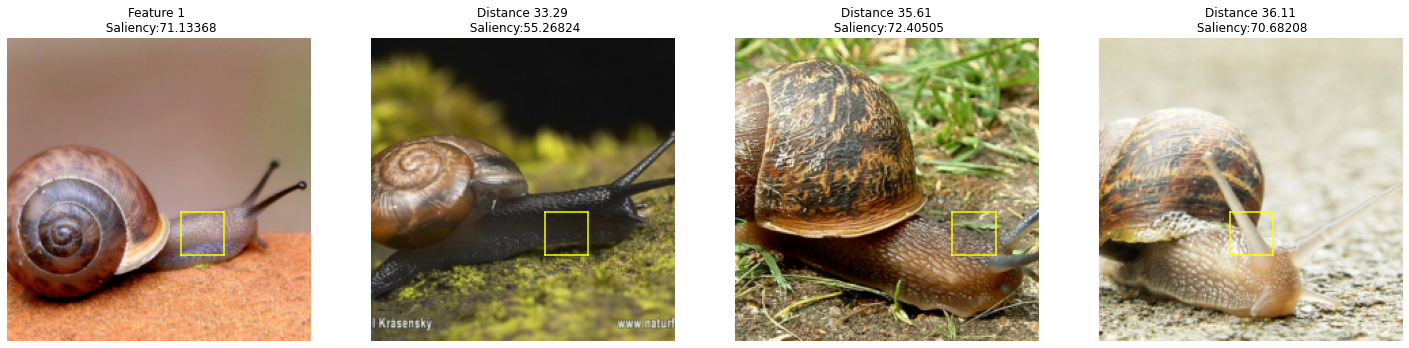

In [30]:
start_time = time.time()
nb_idx = show_twin_sys_explanation_with_blackout(QUERY_IMG, netC)
print("Took Sec:", time.time() - start_time)